In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import streamlit as st
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline
# matplotlib.use('TkAgg')  # Usar un backend interactivo, si es posible
import seaborn as sns

## EDA

In [5]:
# Cargar el dataset
df = pd.read_csv('../youtoxic_english_1000.csv')

In [6]:
# Ver las primeras filas del dataset
print(df.head())

              CommentId      VideoId  \
0  Ugg2KwwX0V8-aXgCoAEC  04kJtp6pVXI   
1  Ugg2s5AzSPioEXgCoAEC  04kJtp6pVXI   
2  Ugg3dWTOxryFfHgCoAEC  04kJtp6pVXI   
3  Ugg7Gd006w1MPngCoAEC  04kJtp6pVXI   
4  Ugg8FfTbbNF8IngCoAEC  04kJtp6pVXI   

                                                Text  IsToxic  IsAbusive  \
0  If only people would just take a step back and...    False      False   
1  Law enforcement is not trained to shoot to app...     True       True   
2  \nDont you reckon them 'black lives matter' ba...     True       True   
3  There are a very large number of people who do...    False      False   
4  The Arab dude is absolutely right, he should h...    False      False   

   IsThreat  IsProvocative  IsObscene  IsHatespeech  IsRacist  IsNationalist  \
0     False          False      False         False     False          False   
1     False          False      False         False     False          False   
2     False          False       True         False     False 

In [7]:
# Resumen de las estadísticas del dataset
print(df.describe())

                   CommentId      VideoId           Text IsToxic IsAbusive  \
count                   1000         1000           1000    1000      1000   
unique                  1000           13            997       2         2   
top     UgjBJKQSoQMQ6ngCoAEC  9pr1oE34bIM  run them over   False     False   
freq                       1          274              3     538       647   

       IsThreat IsProvocative IsObscene IsHatespeech IsRacist IsNationalist  \
count      1000          1000      1000         1000     1000          1000   
unique        2             2         2            2        2             2   
top       False         False     False        False    False         False   
freq        979           839       900          862      875           992   

       IsSexist IsHomophobic IsReligiousHate IsRadicalism  
count      1000         1000            1000         1000  
unique        2            1               2            1  
top       False        False     

In [8]:
# Información general del dataset (tipos de datos y valores nulos)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   CommentId        1000 non-null   object
 1   VideoId          1000 non-null   object
 2   Text             1000 non-null   object
 3   IsToxic          1000 non-null   bool  
 4   IsAbusive        1000 non-null   bool  
 5   IsThreat         1000 non-null   bool  
 6   IsProvocative    1000 non-null   bool  
 7   IsObscene        1000 non-null   bool  
 8   IsHatespeech     1000 non-null   bool  
 9   IsRacist         1000 non-null   bool  
 10  IsNationalist    1000 non-null   bool  
 11  IsSexist         1000 non-null   bool  
 12  IsHomophobic     1000 non-null   bool  
 13  IsReligiousHate  1000 non-null   bool  
 14  IsRadicalism     1000 non-null   bool  
dtypes: bool(12), object(3)
memory usage: 35.3+ KB
None


In [9]:
# Recuento de valores nulos por columna
print(df.isnull().sum())

CommentId          0
VideoId            0
Text               0
IsToxic            0
IsAbusive          0
IsThreat           0
IsProvocative      0
IsObscene          0
IsHatespeech       0
IsRacist           0
IsNationalist      0
IsSexist           0
IsHomophobic       0
IsReligiousHate    0
IsRadicalism       0
dtype: int64


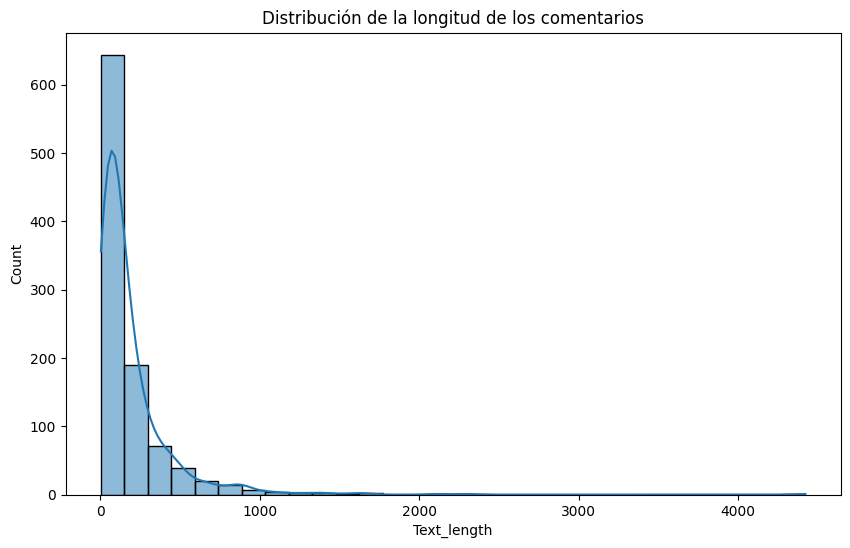

In [17]:
# Distribución de la longitud de los comentarios
df['Text_length'] = df['Text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['Text_length'], kde=True, bins=30)
plt.title('Distribución de la longitud de los comentarios')
plt.show()

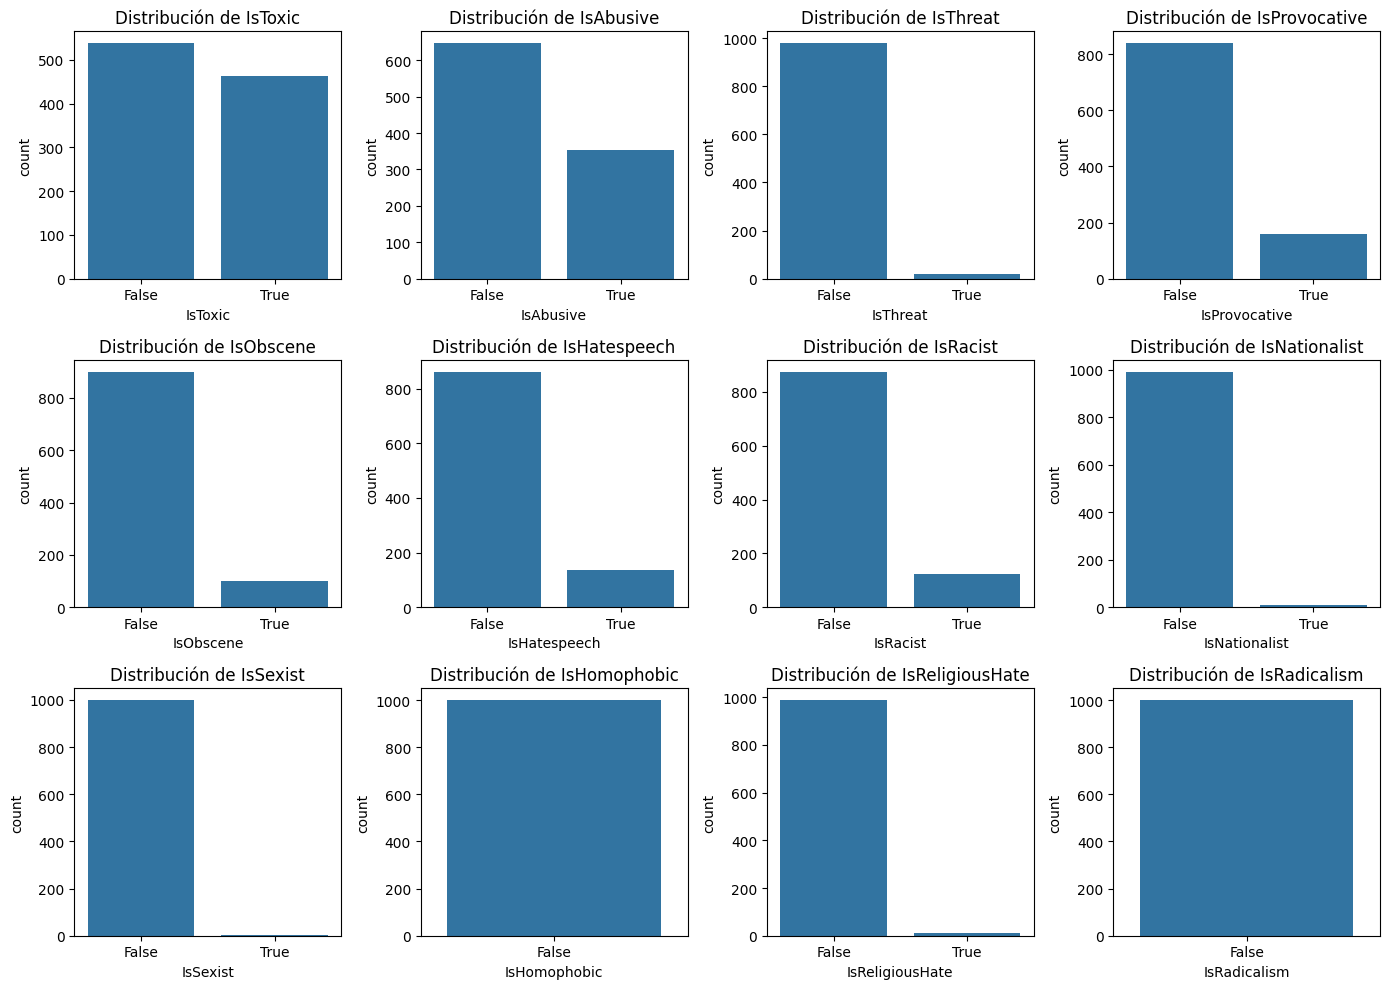

In [18]:
# Ver la cantidad de comentarios por categoría (IsToxic, IsAbusive, etc.)
toxicity_columns = ['IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative', 
                    'IsObscene', 'IsHatespeech', 'IsRacist', 'IsNationalist', 
                    'IsSexist', 'IsHomophobic', 'IsReligiousHate', 'IsRadicalism']

plt.figure(figsize=(14, 10))
for i, column in enumerate(toxicity_columns, 1):
    plt.subplot(3, 4, i)
    sns.countplot(data=df, x=column)
    plt.title(f'Distribución de {column}')
plt.tight_layout()
plt.show()

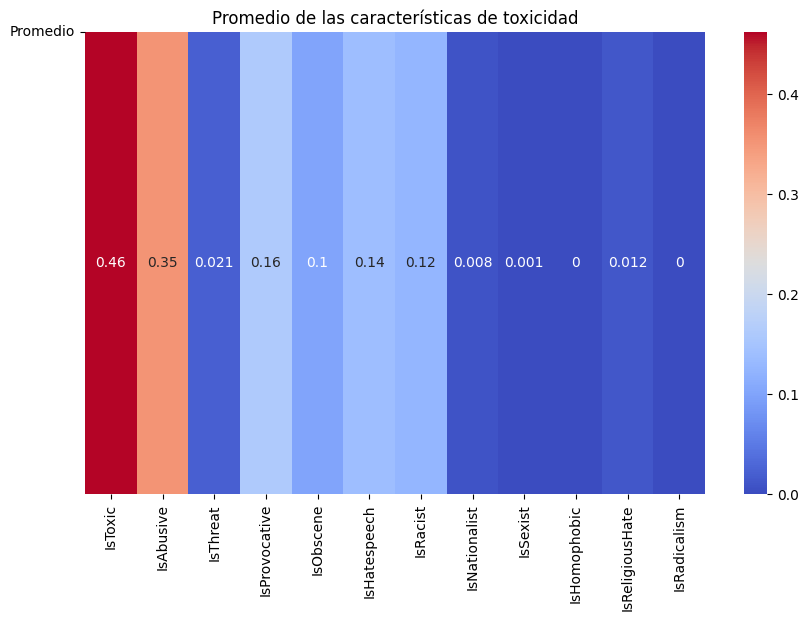

In [26]:
# Análisis de la relación entre las características
plt.figure(figsize=(10, 6))
sns.heatmap(df[toxicity_columns].mean().values.reshape(1, -1), annot=True, cmap='coolwarm', xticklabels=toxicity_columns)
plt.title('Promedio de las características de toxicidad')
plt.yticks([0], ['Promedio'], rotation=0)
plt.show()

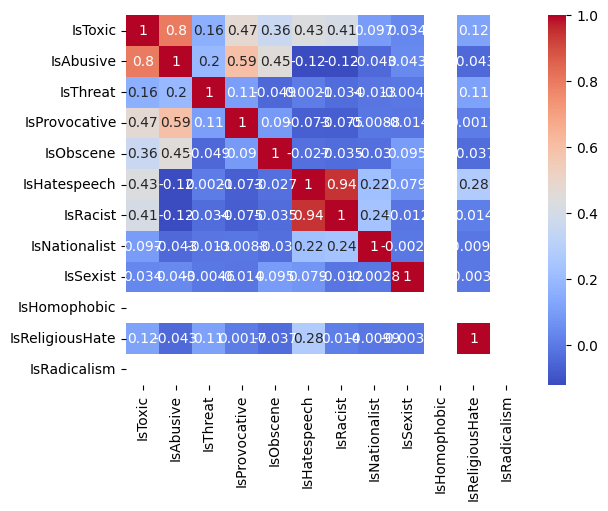

In [29]:
correlation_matrix = df[toxicity_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

Este análisis de correlación muestra que "IsAbusive", "IsProvocative", "IsHatespeech", "IsRacist" y "IsObscene" podrían tener estar más relacionados con la presencia de toxicidad, mientras que no parecen tener ninguna relación con "IsToxic"

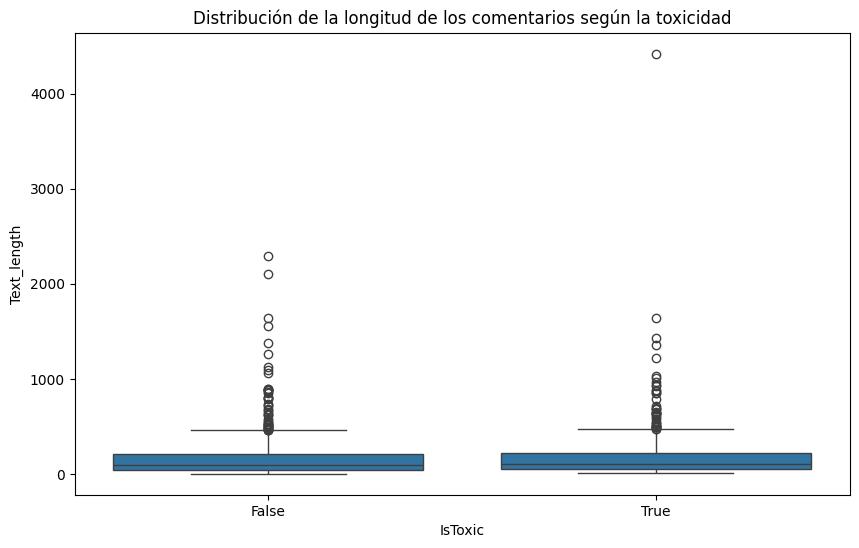

In [20]:
# Análisis de los comentarios que son tóxicos vs no tóxicos
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='IsToxic', y='Text_length')
plt.title('Distribución de la longitud de los comentarios según la toxicidad')
plt.show()

Este gráfico de caja y bigotes muestra la distribución de la longitud de los comentarios (eje y, Text_length) en función de su toxicidad (IsToxic), que está categorizada en False (no tóxico) y True (tóxico).

- Distribución similar entre comentarios tóxicos y no tóxicos: La mediana y el rango intercuartílico (caja) de la longitud de los comentarios parecen ser similares entre ambos grupos. Esto sugiere que no hay una gran diferencia en la longitud promedio de los comentarios tóxicos y no tóxicos.

- Aunque hay algunos comentarios largos (outliers) en ambas categorías, la mayor parte de los comentarios se concentra en el mismo rango de longitud, lo cual sugiere que la toxicidad no depende directamente de la longitud del comentario. Los comentarios tóxicos y no tóxicos pueden ser tanto largos como cortos.

**Este gráfico sugiere que la longitud del comentario no es un factor determinante de su toxicidad, ya que ambos tipos de comentarios muestran distribuciones de longitud similares.**

In [31]:
# Ajustar el máximo de caracteres por celda
pd.set_option('display.max_colwidth', 500)
# Mostrando ejemplos de comentarios tóxicos
toxic_comments = df[df['IsToxic'] == True]['Text'].head(10)
print("Ejemplos de comentarios tóxicos:")
print(toxic_comments)

Ejemplos de comentarios tóxicos:
1                                                                                                                                                                                                                                                                                                Law enforcement is not trained to shoot to apprehend.  They are trained to shoot to kill.  And I thank Wilson for killing that punk bitch.
2     \nDont you reckon them 'black lives matter' banners being held by white cunts is  kinda patronizing and ironically racist. could they have not come up with somethin better.. or is it just what white folks do to give them selves pride. 'ooo look at me im being nice for the black people' why does it always have to be about race actually the whole world is pussyfootin around for fear of being racist. its fuckin daft man.
5                                                                                                              

In [22]:
# Mostrando ejemplos de comentarios no tóxicos
non_toxic_comments = df[df['IsToxic'] == False]['Text'].head(10)
print("Ejemplos de comentarios no tóxicos:")
print(non_toxic_comments)

Ejemplos de comentarios no tóxicos:
0     If only people would just take a step back and...
3     There are a very large number of people who do...
4     The Arab dude is absolutely right, he should h...
8                           I agree with the protestor.
11    moral of the story, don't reach for a cops gun...
18    Thus, with a collapse of the USA, only two pos...
21          LEGALIZE MARIJUANA! Then problems will stop
22                          1 word: Provocateur........
27    This case has overshadowed the cops that murde...
29    "There is blood on the street but you are worr...
Name: Text, dtype: object


In [12]:
class HateSpeechDetector:
    def __init__(self):
        # Usar pipeline para estandarizar el proceso
        self.pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer(
                max_features=3000,  # Reducido para evitar overfitting
                ngram_range=(1, 2),
                min_df=2,  # Ignorar términos que aparecen en menos de 2 documentos
                max_df=0.95,  # Ignorar términos que aparecen en más del 95% de los documentos
                stop_words='english'
            )),
            ('scaler', StandardScaler(with_mean=False)),  # Normalizar características
            ('classifier', LogisticRegression(
                C=0.1,  # Aumentar regularización
                class_weight='balanced',  # Manejar desbalance de clases
                random_state=42,
                max_iter=1000
            ))
        ])
        
    def prepare_target(self, df):
        """Combina todas las columnas objetivo en una sola etiqueta de odio"""
        hate_columns = ['IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative', 
                       'IsObscene', 'IsHatespeech', 'IsRacist', 'IsNationalist', 
                       'IsSexist', 'IsHomophobic', 'IsReligiousHate', 'IsRadicalism']
        return (df[hate_columns].sum(axis=1) > 0).astype(int)
    
    def train(self, df):
        """Entrena el modelo con los datos proporcionados"""
        # Preparar features y target
        X = df['Text']
        y = self.prepare_target(df)
        
        # División del conjunto de datos
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Entrenamiento
        self.pipeline.fit(X_train, y_train)
        
        # Evaluación con validación cruzada
        cv_scores = cross_val_score(self.pipeline, X_train, y_train, cv=5)
        
        # Predicciones finales
        train_pred = self.pipeline.predict(X_train)
        test_pred = self.pipeline.predict(X_test)
        
        train_acc = np.mean(train_pred == y_train)
        test_acc = np.mean(test_pred == y_test)
        
        return {
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'overfitting': train_acc - test_acc,
            'cv_scores_mean': cv_scores.mean(),
            'cv_scores_std': cv_scores.std(),
            'classification_report': classification_report(y_test, test_pred)
        }
    
    def predict(self, text):
        """Predice si un texto contiene mensajes de odio"""
        if isinstance(text, str):
            text = [text]
        return self.pipeline.predict_proba(text)[:, 1]
    
    def save_model(self, path):
        """Guarda el modelo entrenado"""
        joblib.dump(self.pipeline, path)
    
    @classmethod
    def load_model(cls, path):
        """Carga un modelo guardado"""
        detector = cls()
        detector.pipeline = joblib.load(path)
        return detector

In [13]:
# Interfaz Streamlit
def create_streamlit_app():
    st.title("Detector de Mensajes de Odio")
    
    # Cargar modelo
    try:
        detector = HateSpeechDetector.load_model('hate_speech_model.pkl')
    except:
        st.error("No se encontró un modelo entrenado. Por favor, entrene el modelo primero.")
        return
    
    # Área de texto para input
    text_input = st.text_area("Introduce el texto a analizar:")
    
    if st.button("Analizar"):
        if text_input:
            probability = detector.predict(text_input)[0]
            st.write(f"Probabilidad de contenido de odio: {probability:.2%}")
            
            if probability > 0.5:
                st.error("⚠️ Este texto puede contener mensajes de odio.")
            else:
                st.success("✅ Este texto parece seguro.")
        else:
            st.warning("Por favor, introduce algún texto para analizar.")

if __name__ == "__main__":
    # Cargar y entrenar el modelo
    df = pd.read_csv('../youtoxic_english_1000.csv')
    detector = HateSpeechDetector()
    metrics = detector.train(df)
    print("Métricas del modelo:")
    for key, value in metrics.items():
        print(f"{key}: {value}")
    
    # Guardar el modelo
    detector.save_model('hate_speech_model.pkl')
    
    # Crear interfaz Streamlit
    create_streamlit_app()

Métricas del modelo:
train_accuracy: 0.995
test_accuracy: 0.675
overfitting: 0.31999999999999995
cv_scores_mean: 0.62375
cv_scores_std: 0.024811791551599
classification_report:               precision    recall  f1-score   support

           0       0.69      0.72      0.71       108
           1       0.66      0.62      0.64        92

    accuracy                           0.68       200
   macro avg       0.67      0.67      0.67       200
weighted avg       0.67      0.68      0.67       200

